In [ ]:
#Hamiltonian
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from google.colab import files
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#U Devuelve la energia potencial de U, dado un valor de Q
def U(q):
  if q>0:
    return(-4*np.log(q)+np.log(24)+q) 
  else:
    return(0)
       #El logaritmo de la densidad que queremos simular, U(q) hacer referencia a la funcion de energía potencial 

#Gradiente de U dado q
def grad_U(q):   #El gradiente de la función U, que se utilizará para resolver el sistema de ecuaciones dado por las dinámicas hamiltonianas
  return(-(4/q)+1)

In [ ]:
def HMCMC(U, grad_U, epsilon, L, inicial_q, N):
  #En el primer paso nuevos valores son  escogidos para el momentum, p, aleatoriamente de una distribución normal, y son independientes de la posición q. 
  mu, sigma = 0, 1 # Parametros de la normal
  
  q = inicial_q #El punto de inicio del algoritmo
  cadena=q
  rechazos=0

  for i in range(1,N): 
    p = np.array([np.random.normal(mu, sigma, q.shape[1])])  #Asignamos el nuevo valor de p, independiente de q

    actual_p = p  
  #  Empieza el algoritmo de Leap Frog para resolver el sistema de ecuaciones diferenciales dada por la dinamica de H 
    p=p- epsilon * grad_U(q) / 2
    for i in range(1,L+1):
      q= q+epsilon*p
  #paso completo para el momento excepto en la ultima
      if(i!=L):
        p=p-epsilon*grad_U(q)

    p= p - epsilon * grad_U(q) / 2   ##termina el algoritmo de Leap Frog 
  # Hacemos la propuesta simétrica cambiando el signo 
    p = -p
    actual_U = U(inicial_q)
    actual_K = np.sum(actual_p**2) / 2
    propuesta_U = U(q)
    propuesta_K = np.sum(p**2) / 2
  # Aceptamos o rechazamos el estado propuesto
    if random.uniform(0, 1) < np.exp(actual_U-propuesta_U+actual_K-propuesta_K) and q>0:
      cadena=np.r_[cadena,q]
      inicial_q=q

    else:
      cadena=np.r_[cadena,inicial_q]
      rechazos=rechazos+1
  return(cadena, rechazos)


In [ ]:
np.random.seed(0)
random.seed(0)
t0 = time.time()
simulacion=HMCMC(U,grad_U,5,6,np.array([[500]]),100000)
t1 = time.time()
print("--- %s segundos ---" % (t1- t0))

--- 19.01598834991455 segundos ---


##Tasa de rechazo

In [ ]:
cadena_bruta= simulacion[0]
tasa_rechazo= simulacion[1]/(cadena_bruta.shape[0]-1)
tasa_rechazo

0.999989999899999

##EJEMPLO 2

In [ ]:

np.random.seed(0)
random.seed(0)
t0 = time.time()

simulacion1=HMCMC(U,grad_U,0.09,47,np.array([[500]]),100000)
t1 = time.time()
print("--- %s segundos ---" % (t1- t0)) #tiempo de ejecucion


--- 44.377501249313354 segundos ---


In [ ]:
cadena_bruta1= simulacion1[0]
tasa_rechazo1= simulacion1[1]/(cadena_bruta1.shape[0]-1)
1-tasa_rechazo1  #tasa de aceptacion

0.999639996399964

## Burnin de manera gráfica

In [ ]:
def log_densidades_gamma_r(muest):    #log probabilidades
  return(np.log(1/24)+4*np.log(muest)-muest)

vector_verosim2 = np.zeros(100)
for i in range(0,100):
  vector_verosim2[i]=log_densidades_gamma_r(cadena_bruta1[i])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

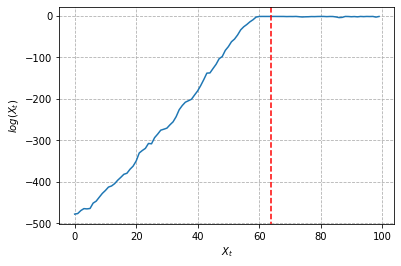

In [ ]:
burnin=64
plt.grid(linestyle='dashed')
plt.plot(vector_verosim2)
plt.ylabel('$log(X_{t})$')
plt.xlabel('$X_{t}$')
plt.axvline(burnin,-100,100,  color="red",  linestyle='dashed')
#plt.savefig("burnhmc1.png",bbox_inches='tight',dpi=300)
#files.download("burnhmc1.png")

##Burnin con distancias de Hellinger 

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("LaplacesDemon") #Cargamos la paqueteria 
library("LaplacesDemon")


In [ ]:
%R -i cadena_bruta1 #pasamos la cadena a R


In [ ]:
%%R

burn1<-BMK.Diagnostic(cadena_bruta1, 200) #hacemos  200 subconjuntos


burnin_DH=as.numeric(c(0,colnames(burn1))[which.max(c(0,which(burn1>.5)))])  #Desechamos los subconjuntos a partir del último con
#diferencia mayor a 0.5
burnin_DH

[1] 0


utilizaremos el burnin obtenido del método grafico 

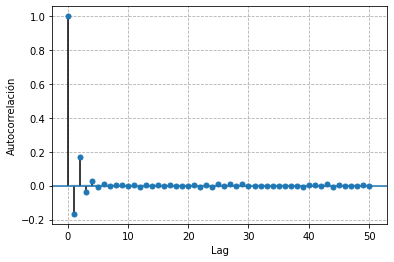

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
cadena_sb=cadena_bruta1[64:99999]   #quitamos las primeras 280 muestras
fig=plot_acf(cadena_sb, lags=50,alpha=0.05)  #autocorrelaciones 
plt.grid(linestyle='dashed')
plt.title("")
plt.ylabel('Autocorrelación')
plt.xlabel('Lag')
pyplot.show()
fig.savefig("autocor_1.png",bbox_inches='tight',dpi=300)
files.download("autocor_1.png") 

##Lag con IAT

In [ ]:
%R -i cadena_sb
%R iat1=IAT(cadena_sb)
%R  iat1

array([0.98181874])

In [ ]:
lag = %R iat1
lag= math.ceil(lag) #redondeamos hacia arriba
lag

1

In [ ]:
cadena_sl= cadena_sb[np.arange(0,len(cadena_sb),lag)]  #cadena sin lag


##Muestra total

In [ ]:
len(cadena_sl)

99935

##Densidad

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

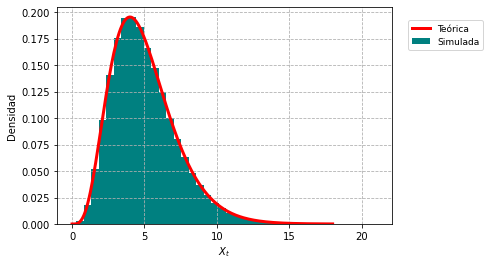

In [ ]:

x=np.linspace(0,18,200)
x_pdf=ss.gamma.pdf(x,a=5,scale=1)    #parametrizada, alfa = 5, betta=10
plt.plot(x,x_pdf, color="red",  linewidth=3)

plt.hist(cadena_sl, bins = int(40), density=True, color='teal')
#plt.title(" ")
plt.grid(linestyle='dashed')
plt.legend(('Teórica', 'Simulada'), bbox_to_anchor=(1.05,0.8), loc=3, borderaxespad=0, prop={'size':9})
plt.ylabel('Densidad')
plt.xlabel('$X_{t}$')

plt.savefig("densidadgamahmc.png",bbox_inches='tight',dpi=300)
files.download("densidadgamahmc.png")